In [1]:
import gstools as gs
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.spatial.distance import cdist
import yaml
import sys
import os
# Dynamically determine the project root directory
project_root = Path(os.getcwd()).parent
sys.path.insert(0, str(project_root))
from src.data_loading.simple_loader import load_processed_berkeley_earth, load_processed_era5, load_config, load_processed_elevation_data, load_processed_station_density_data

# load processed data
# load station density data
# process station density data 
# create exploratory plots of features to difference for western united states


In [16]:
class TemperatureDatasetMetrics:
    
    def __init__(self, variable='tavg'):
        """
        Initialize with a specific temperature variable.

        Variables: 'tavg', 'tmin', 'tmax'
        """
        self.variable = variable
        self.be_data = load_processed_berkeley_earth(variable)
        self.be_data['abs_temp'] = self.be_data.temperature.groupby('time.month')+self.be_data.climatology.rename({'month_number': 'month'})

        self.era5_data = load_processed_era5(variable)
        self.era5_data['abs_temp'] = self.era5_data.temperature.groupby('time.month') + self.era5_data.climatology - 273.15
        
        self.difference= self.be_data.temperature - self.era5_data.temperature
        self.abs_difference = self.be_data.abs_temp - self.era5_data.abs_temp
        
        self.config = load_config()
        
    def slice_data(self, time_slice=('1940-01-01', '2025-01-01'), lat_slice=(-90, 90), lon_slice=(-180, 180), land_only_flag=False):
        """Slice the data based on time, latitude, and longitude."""
        
        if land_only_flag:
            self.be_slice = self.be_data.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice)).where(self.be_data.land_mask)
            self.era5_slice = self.era5_data.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice)).where(self.be_data.land_mask)
            self.difference_slice = self.difference.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice)).where(self.be_data.land_mask)
            self.abs_difference_slice = self.abs_difference.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice)).where(self.be_data.land_mask)
        else:
            self.be_slice = self.be_data.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice))
            self.era5_slice = self.era5_data.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice))
            self.difference_slice = self.difference.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice))
            self.abs_difference_slice = self.abs_difference.sel(time=slice(*time_slice), latitude=slice(*lat_slice), longitude=slice(*lon_slice))

def seasonal_weighted_by_year(da, season):
    """Month-length–weighted seasonal means per year for one season."""
    sel = da.where(da['time.season'] == season, drop=True)
    w = sel.time.dt.days_in_month  # weights

    # Year labeling: for DJF, count December toward the NEXT year
    yr = xr.where(sel.time.dt.month == 12, sel.time.dt.year + 1, sel.time.dt.year) \
         if season == "DJF" else sel.time.dt.year

    # weighted mean within each season-year: sum(da*w)/sum(w)
    num = (sel * w).groupby(yr).sum(dim="time")
    den = w.groupby(yr).sum()
    out = num / den
    out = out.rename({"group": "year"}) if "group" in out.dims else out  # xarray may name it "group"
    out = out.assign_coords(year=out["year"])  # ensure coord exists for clarity
    return out



def map_plots(ds1,ds2,title1,title2):
    # compare summer tavg temperatures
    plt.figure(figsize=(18, 6))
    ax1 = plt.subplot(1, 3, 1, projection=ccrs.PlateCarree())
    ds1.plot(ax=ax1, transform=ccrs.PlateCarree(),vmin=-5)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
    ax1.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree())
    ax1.set_title(title1)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude') 

    ax1 = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree())
    ds2.plot(ax=ax1, transform=ccrs.PlateCarree(),vmin=-5)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
    ax1.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree())
    ax1.set_title(title2)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude') 

    ax1 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
    (ds1-ds2).plot(ax=ax1, transform=ccrs.PlateCarree())
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
    ax1.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree())
    ax1.set_title('Difference')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude') 


def variogram(lats,lons,temps):
    """Calculate variograms using gstools"""
    bc,gamma = gs.vario_estimate(
        (lons, lats), temps,
        mesh_type="structured",
        latlon=True,
        geo_scale=np.degrees(1.0),
        bin_no=30,
        max_dist=5,
        sampling_size=1000
    )
    fit_model = gs.Stable(dim=2)
    fit_model.fit_variogram(bc,gamma,nugget=False)
    return fit_model, bc, gamma


def plot_variogram(lats,lons,be,era5,ax1):
    fit_model, bc, gamma = variogram(lats,lons,be)
    er_model, er_bc, er_gamma = variogram(lats,lons,era5)
    fit_model.plot(ax=ax1,color='blue',x_max=max(bc))
    ax1.scatter(bc,gamma,color='blue')
    er_model.plot(ax=ax1,color='red',x_max=max(er_bc))
    ax1.scatter(er_bc,er_gamma,color='red')


def map_plots_v2(ds1,ds2,title1,title2,lats,lons):
    # calculate temporal mean
    ds1_mean = ds1.mean(dim='year')
    ds2_mean = ds2.mean(dim='year')
    
    ds1_time_mean = ds1.mean(dim=['latitude','longitude'])
    ds2_time_mean = ds2.mean(dim=['latitude','longitude'])

    # compare summer tavg temperatures
    plt.figure(figsize=(18, 6))
    ax1 = plt.subplot(2, 3, 1, projection=ccrs.PlateCarree())
    ds1_mean.plot(ax=ax1, transform=ccrs.PlateCarree(),vmin=-5)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
    ax1.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree())
    ax1.set_title(title1)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude') 

    ax1 = plt.subplot(2, 3, 2, projection=ccrs.PlateCarree())
    ds2_mean.plot(ax=ax1, transform=ccrs.PlateCarree(),vmin=-5)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
    ax1.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree())
    ax1.set_title(title2)
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude') 

    ax1 = plt.subplot(2, 3, 3, projection=ccrs.PlateCarree())
    (ds1_mean-ds2_mean).plot(ax=ax1, transform=ccrs.PlateCarree())
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
    ax1.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree())
    ax1.set_title('Difference')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude') 

    ax1 = plt.subplot(2,3,4)
    fit_model, bc, gamma = variogram(lats,lons,ds1_mean)
    er_model, er_bc, er_gamma = variogram(lats,lons,ds2_mean)
    fit_model.plot(ax=ax1,color='blue',x_max=max(bc))
    ax1.scatter(bc,gamma,color='blue')
    er_model.plot(ax=ax1,color='red',x_max=max(er_bc))
    ax1.scatter(er_bc,er_gamma,color='red')

    ax1 = plt.subplot(2,3,5)
    ds1_time_mean.plot(ax=ax1, color='blue')
    ds2_time_mean.plot(ax=ax1, color='red')
    ax1.set_title('')

    ax1 = plt.subplot(2,3,6)
    diff = ds1 - ds2
    # remove 0's from diff
    diff = diff.where(diff != 0, drop=True)

    diff.plot.hist(bins=100, ax=ax1)
    mean = diff.mean().item()
    std = diff.std().item()
    #ax1.text(-3, 15000, f'Mean: {mean:.2f}')
    #ax1.text(-3, 10000, f'std: {std:.2f}')
    ax1.set_title(f'mean: {mean:.2f}, std: {std:.2f}')
    

    


In [9]:
# load temperature data and calculate difference, load elevation data, load station density data
#TAVG = TemperatureDatasetMetrics(variable='tavg')
time_slice = ('2000-01-01', '2024-12-31')
lat_slice = (35, 70)
lon_slice = (-10, 40)
#TAVG.slice_data(time_slice=time_slice, lat_slice=lat_slice, lon_slice=lon_slice, land_only_flag=True)

TMAX = TemperatureDatasetMetrics(variable='tmax')
TMAX.slice_data(time_slice=time_slice, lat_slice=lat_slice, lon_slice=lon_slice, land_only_flag=True)

TMIN = TemperatureDatasetMetrics(variable='tmin')
TMIN.slice_data(time_slice=time_slice, lat_slice=lat_slice, lon_slice=lon_slice, land_only_flag=True)




Text(0.5, 1.0, 'mean: 0.03, std: 0.68')

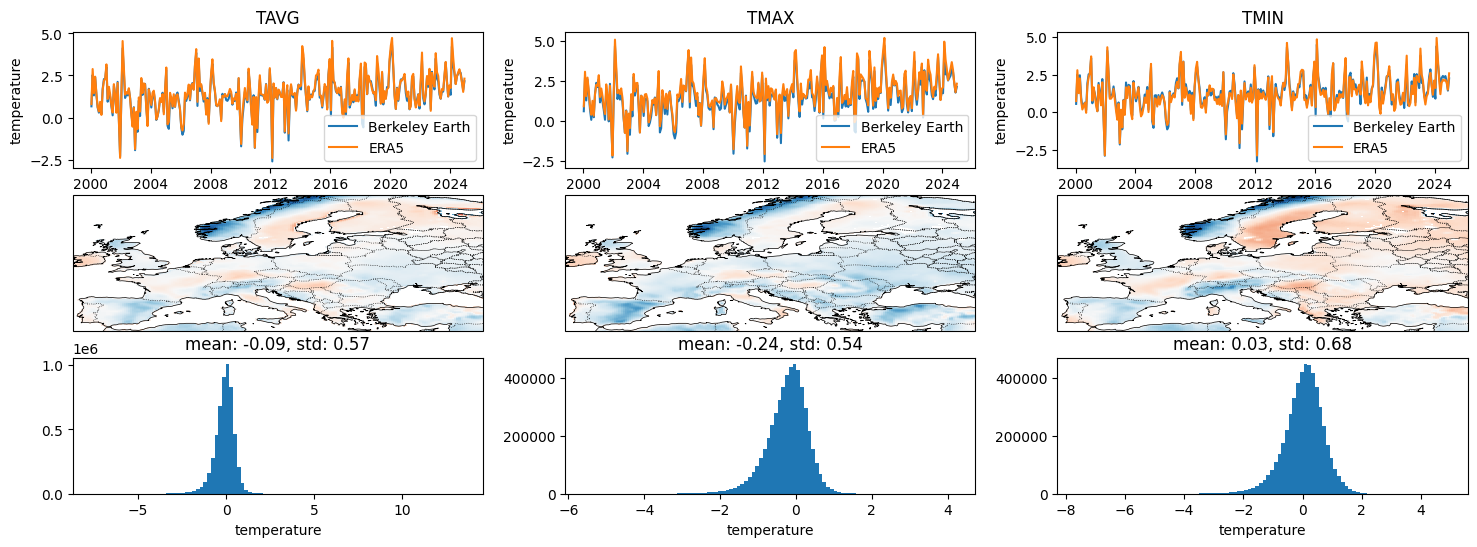

In [ ]:
weights = TAVG.be_slice.areal_weight.fillna(0)
BE_avg = TAVG.be_slice.temperature.weighted(weights).mean(dim=['latitude','longitude'])
ER_avg = TAVG.era5_slice.temperature.weighted(weights).mean(dim=['latitude','longitude'])
BE_avg_max = TMAX.be_slice.temperature.weighted(weights).mean(dim=['latitude','longitude'])
ER_avg_max = TMAX.era5_slice.temperature.weighted(weights).mean(dim=['latitude','longitude'])
BE_avg_min = TMIN.be_slice.temperature.weighted(weights).mean(dim=['latitude','longitude'])
ER_avg_min = TMIN.era5_slice.temperature.weighted(weights).mean(dim=['latitude','longitude'])
cmap = 'RdBu_r'
vec = [-10, 40, 35, 70]
plt.figure(figsize=(18,6))
ax1 = plt.subplot(3,3,1)
BE_avg.plot(ax=ax1,label='Berkeley Earth')
ER_avg.plot(ax=ax1, label='ERA5')
plt.legend()
plt.title('TAVG')

ax1 = plt.subplot(3,3,2)
BE_avg_max.plot(ax=ax1,label='Berkeley Earth')
ER_avg_max.plot(ax=ax1, label='ERA5')
plt.legend()
plt.title('TMAX')

ax1 = plt.subplot(3,3,3)
BE_avg_min.plot(ax=ax1,label='Berkeley Earth')
ER_avg_min.plot(ax=ax1, label='ERA5')
plt.legend()
plt.title('TMIN')

ax1 = plt.subplot(3,3,4,projection=ccrs.PlateCarree())
pcm1 = (TAVG.be_slice.temperature.mean(dim='time')-TAVG.era5_slice.temperature.mean(dim='time')).plot(ax=ax1, transform=ccrs.PlateCarree(),add_colorbar=False, vmin=-2,vmax=2,cmap=cmap)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
ax1.set_extent(vec, crs=ccrs.PlateCarree())
ax1.set_aspect('auto')
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude') 

ax1 = plt.subplot(3,3,5,projection=ccrs.PlateCarree())
(TMAX.be_slice.temperature.mean(dim='time')-TMAX.era5_slice.temperature.mean(dim='time')).plot(ax=ax1, transform=ccrs.PlateCarree(),add_colorbar=False, vmin=-2,vmax=2,cmap=cmap)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
ax1.set_extent(vec, crs=ccrs.PlateCarree())
ax1.set_aspect('auto')
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude') 

ax1 = plt.subplot(3,3,6,projection=ccrs.PlateCarree())
(TMIN.be_slice.temperature.mean(dim='time')-TMIN.era5_slice.temperature.mean(dim='time')).plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=-2,vmax=2,add_colorbar=False,cmap=cmap)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
ax1.set_extent(vec, crs=ccrs.PlateCarree())
ax1.set_aspect('auto')
ax1.set_title('')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude') 

diff_tavg = TAVG.be_slice.temperature - TAVG.era5_slice.temperature
diff_tmax = TMAX.be_slice.temperature - TMAX.era5_slice.temperature
diff_tmin = TMIN.be_slice.temperature - TMIN.era5_slice.temperature

# plot histograms of differences
ax1 = plt.subplot(3,3,7)
diff_tavg.plot.hist(bins=100, ax=ax1)
mean = diff_tavg.mean().item()
std = diff_tavg.std().item()
ax1.set_title(f'mean: {mean:.2f}, std: {std:.2f}')

ax1 = plt.subplot(3,3,8)
diff_tmax.plot.hist(bins=100, ax=ax1)
mean = diff_tmax.mean().item()
std = diff_tmax.std().item()
ax1.set_title(f'mean: {mean:.2f}, std: {std:.2f}')

ax1 = plt.subplot(3,3,9)
diff_tmin.plot.hist(bins=100, ax=ax1)
mean = diff_tmin.mean().item()
std = diff_tmin.std().item()
ax1.set_title(f'mean: {mean:.2f}, std: {std:.2f}')

In [7]:
da = TAVG.be_slice.temperature
BE_winter = seasonal_weighted_by_year(da, "DJF") 
BE_spring = seasonal_weighted_by_year(da, "MAM") 
BE_summer = seasonal_weighted_by_year(da, "JJA") 
BE_fall = seasonal_weighted_by_year(da, "SON") 
da = TAVG.era5_slice.temperature
ER_winter = seasonal_weighted_by_year(da, "DJF") 
ER_spring = seasonal_weighted_by_year(da, "MAM") 
ER_summer = seasonal_weighted_by_year(da, "JJA") 
ER_fall = seasonal_weighted_by_year(da, "SON")

In [11]:
da = TAVG.be_slice.temperature
BE_winter = seasonal_weighted_by_year(da, "DJF") 
BE_spring = seasonal_weighted_by_year(da, "MAM") 
BE_summer = seasonal_weighted_by_year(da, "JJA") 
BE_fall = seasonal_weighted_by_year(da, "SON") 

da = TAVG.era5_slice.temperature
ER_winter = seasonal_weighted_by_year(da, "DJF") 
ER_spring = seasonal_weighted_by_year(da, "MAM") 
ER_summer = seasonal_weighted_by_year(da, "JJA") 
ER_fall = seasonal_weighted_by_year(da, "SON") 

da = TMAX.be_slice.temperature
BE_winter_max = seasonal_weighted_by_year(da, "DJF") 
BE_spring_max = seasonal_weighted_by_year(da, "MAM") 
BE_summer_max = seasonal_weighted_by_year(da, "JJA") 
BE_fall_max = seasonal_weighted_by_year(da, "SON") 

da = TMAX.era5_slice.temperature
ER_winter_max = seasonal_weighted_by_year(da, "DJF") 
ER_spring_max = seasonal_weighted_by_year(da, "MAM") 
ER_summer_max = seasonal_weighted_by_year(da, "JJA") 
ER_fall_max = seasonal_weighted_by_year(da, "SON") 

da = TMIN.be_slice.temperature
BE_winter_min = seasonal_weighted_by_year(da, "DJF") 
BE_spring_min = seasonal_weighted_by_year(da, "MAM") 
BE_summer_min = seasonal_weighted_by_year(da, "JJA") 
BE_fall_min = seasonal_weighted_by_year(da, "SON") 

da = TMIN.era5_slice.temperature
ER_winter_min = seasonal_weighted_by_year(da, "DJF") 
ER_spring_min = seasonal_weighted_by_year(da, "MAM") 
ER_summer_min = seasonal_weighted_by_year(da, "JJA") 
ER_fall_min = seasonal_weighted_by_year(da, "SON") 

Text(0.5, 1.0, 'Fall (SON)')

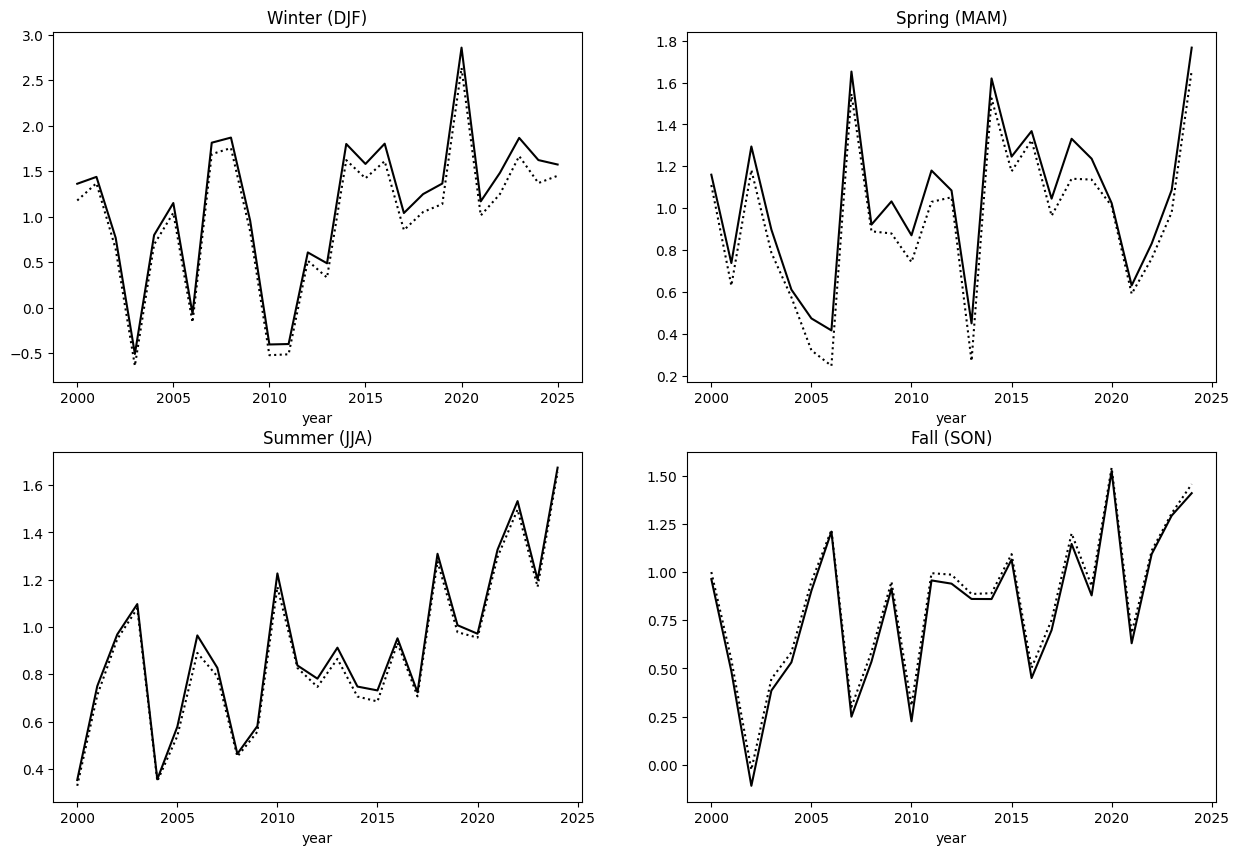

In [12]:
# plot time series comparison
plt.figure(figsize=(15,10))
ax1 = plt.subplot(2, 2, 1)
BE_winter.mean(dim=['latitude','longitude']).plot(ax=ax1, color='black',linestyle=':')
ER_winter.mean(dim=['latitude','longitude']).plot(ax=ax1, color='black')
plt.title('Winter (DJF)')
ax1 = plt.subplot(2, 2, 2)
BE_spring.mean(dim=['latitude','longitude']).plot(ax=ax1, color='black',linestyle=':')
ER_spring.mean(dim=['latitude','longitude']).plot(ax=ax1, color='black')
plt.title('Spring (MAM)')
ax1 = plt.subplot(2, 2, 3)
BE_summer.mean(dim=['latitude','longitude']).plot(ax=ax1, color='black',linestyle=':')
ER_summer.mean(dim=['latitude','longitude']).plot(ax=ax1, color='black')
plt.title('Summer (JJA)')
ax1 = plt.subplot(2, 2, 4)
BE_fall.mean(dim=['latitude','longitude']).plot(ax=ax1, color='black',linestyle=':')
ER_fall.mean(dim=['latitude','longitude']).plot(ax=ax1, color='black')
plt.title('Fall (SON)')

Text(0.5, 1.0, 'Fall (SON)')

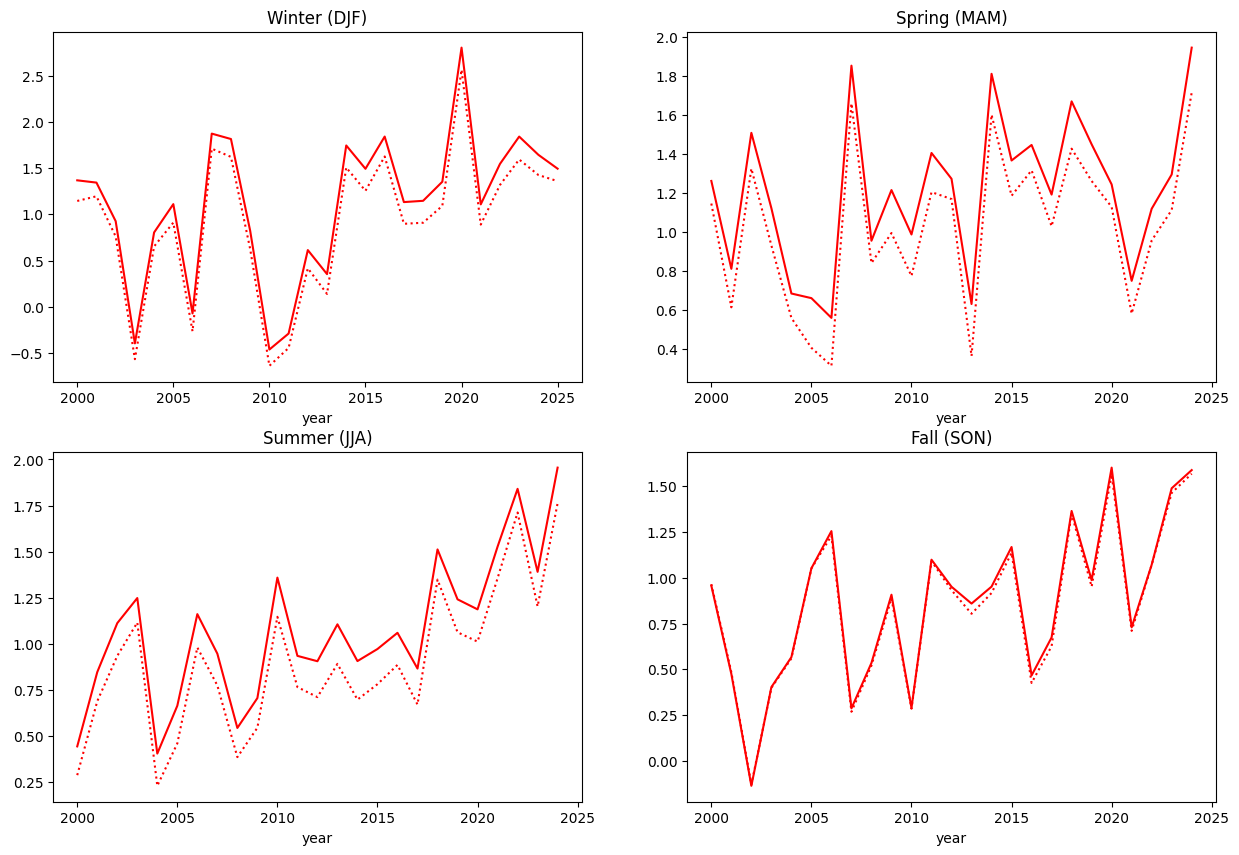

In [13]:
# plot time series comparison
plt.figure(figsize=(15,10))
ax1 = plt.subplot(2, 2, 1)
BE_winter_max.mean(dim=['latitude','longitude']).plot(ax=ax1, color='red',linestyle=':')
ER_winter_max.mean(dim=['latitude','longitude']).plot(ax=ax1, color='red')
plt.title('Winter (DJF)')
ax1 = plt.subplot(2, 2, 2)
BE_spring_max.mean(dim=['latitude','longitude']).plot(ax=ax1, color='red',linestyle=':')
ER_spring_max.mean(dim=['latitude','longitude']).plot(ax=ax1, color='red')
plt.title('Spring (MAM)')
ax1 = plt.subplot(2, 2, 3)
BE_summer_max.mean(dim=['latitude','longitude']).plot(ax=ax1, color='red',linestyle=':')
ER_summer_max.mean(dim=['latitude','longitude']).plot(ax=ax1, color='red')
plt.title('Summer (JJA)')
ax1 = plt.subplot(2, 2, 4)
BE_fall_max.mean(dim=['latitude','longitude']).plot(ax=ax1, color='red',linestyle=':')
ER_fall_max.mean(dim=['latitude','longitude']).plot(ax=ax1, color='red')
plt.title('Fall (SON)')

Text(0.5, 1.0, 'Fall (SON)')

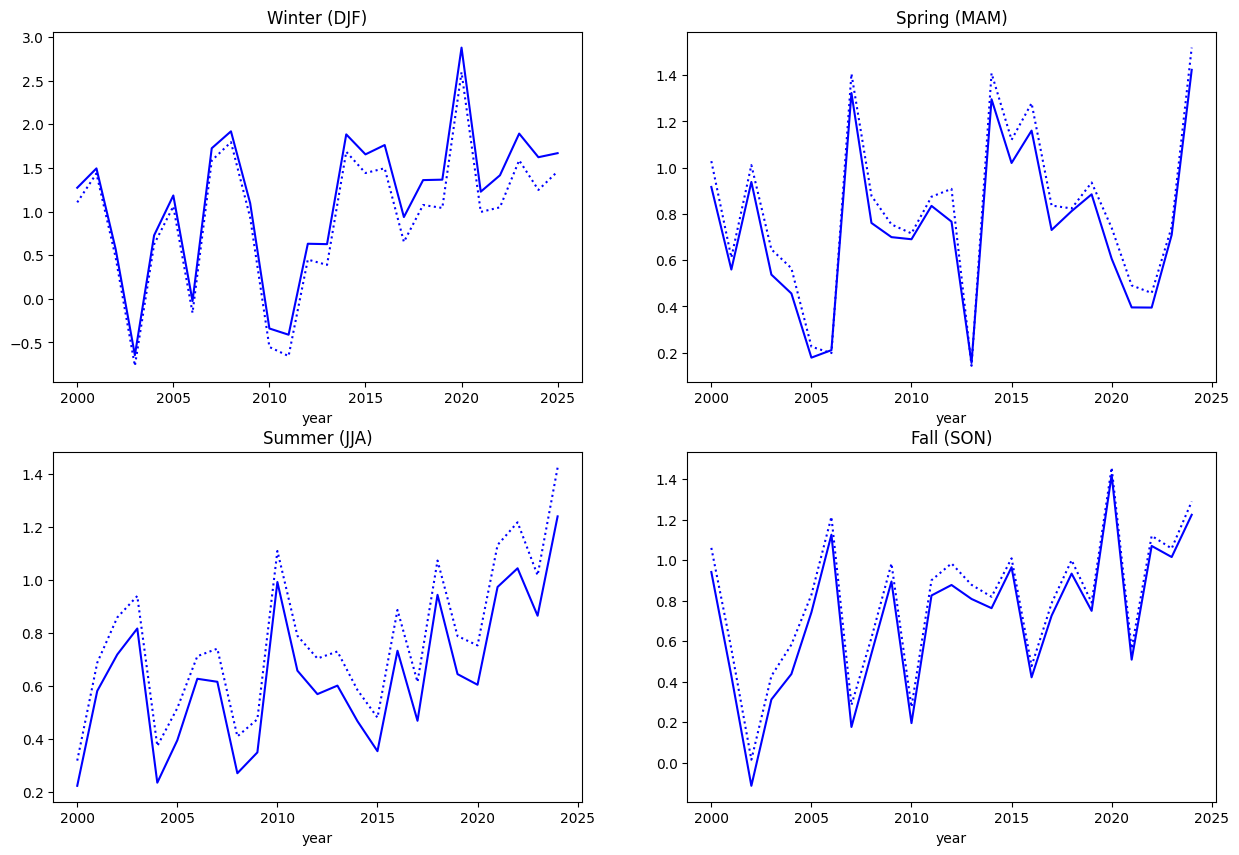

In [14]:
# plot time series comparison
plt.figure(figsize=(15,10))
ax1 = plt.subplot(2, 2, 1)
BE_winter_min.mean(dim=['latitude','longitude']).plot(ax=ax1, color='blue',linestyle=':')
ER_winter_min.mean(dim=['latitude','longitude']).plot(ax=ax1, color='blue')
plt.title('Winter (DJF)')
ax1 = plt.subplot(2, 2, 2)
BE_spring_min.mean(dim=['latitude','longitude']).plot(ax=ax1, color='blue',linestyle=':')
ER_spring_min.mean(dim=['latitude','longitude']).plot(ax=ax1, color='blue')
plt.title('Spring (MAM)')
ax1 = plt.subplot(2, 2, 3)
BE_summer_min.mean(dim=['latitude','longitude']).plot(ax=ax1, color='blue',linestyle=':')
ER_summer_min.mean(dim=['latitude','longitude']).plot(ax=ax1, color='blue')
plt.title('Summer (JJA)')
ax1 = plt.subplot(2, 2, 4)
BE_fall_min.mean(dim=['latitude','longitude']).plot(ax=ax1, color='blue',linestyle=':')
ER_fall_min.mean(dim=['latitude','longitude']).plot(ax=ax1, color='blue')
plt.title('Fall (SON)')

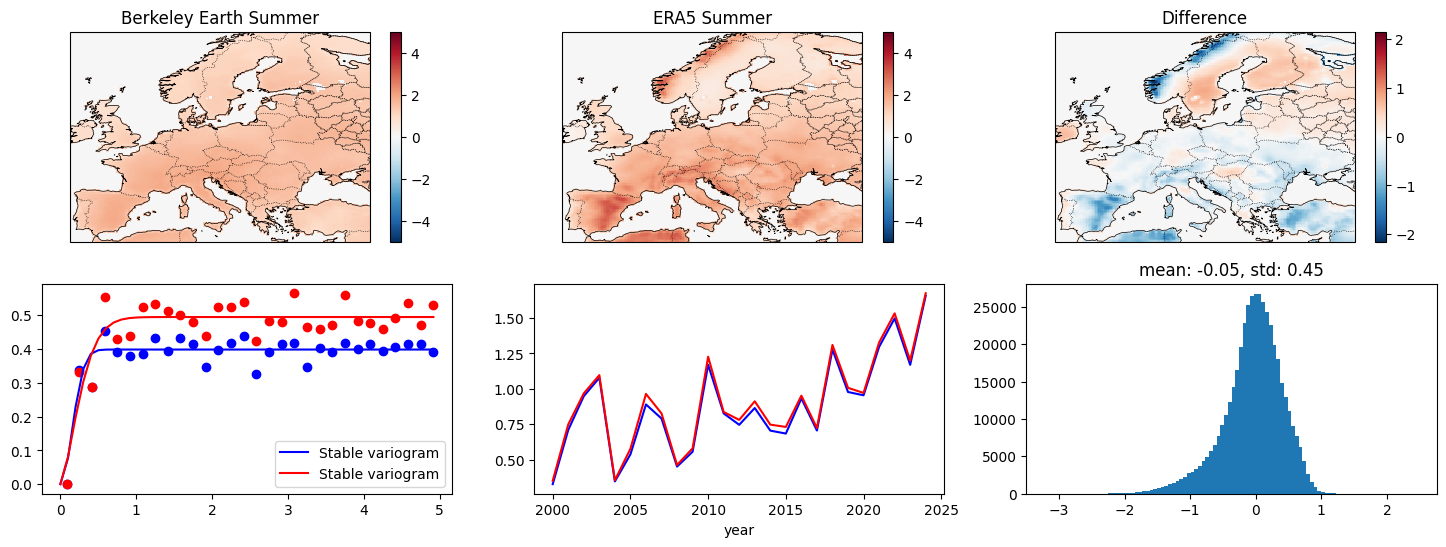

In [17]:
# compare summer tavg temperatures
ds1 = BE_summer
ds2 = ER_summer
lats = TAVG.be_slice.latitude
lons = TAVG.be_slice.longitude
map_plots_v2(ds1,ds2,'Berkeley Earth Summer','ERA5 Summer',lats,lons)

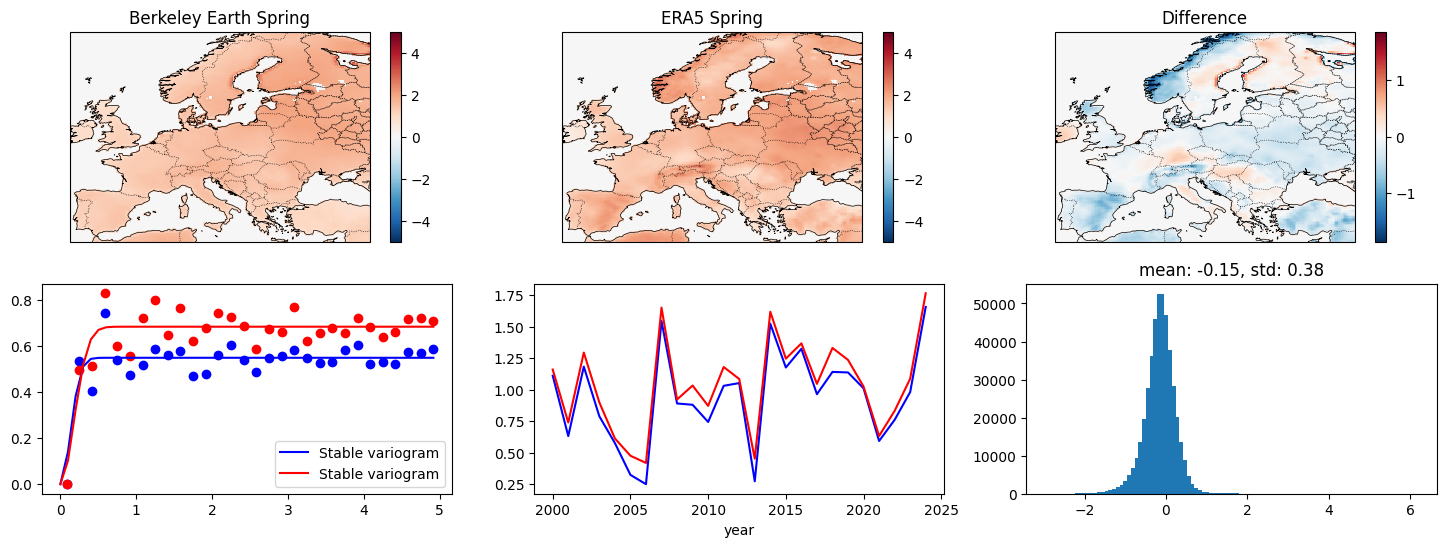

In [18]:
ds1 = BE_spring
ds2 = ER_spring
map_plots_v2(ds1,ds2,'Berkeley Earth Spring','ERA5 Spring',lats,lons)

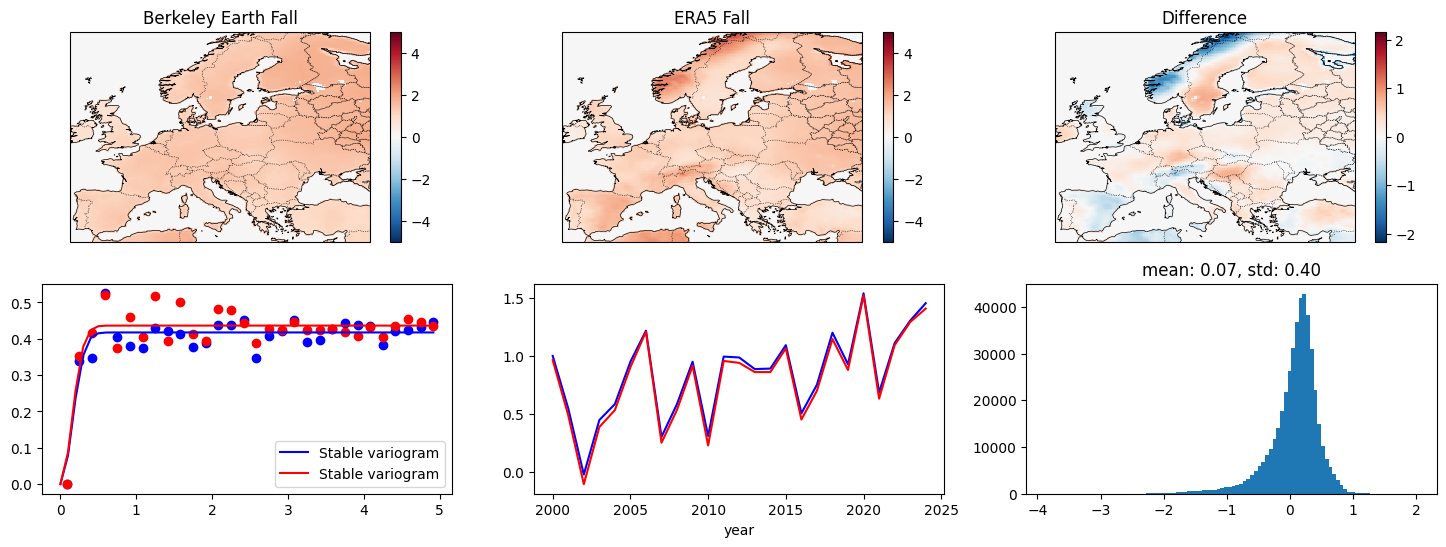

In [19]:
ds1 = BE_fall
ds2 = ER_fall
map_plots_v2(ds1,ds2,'Berkeley Earth Fall','ERA5 Fall',lats,lons)

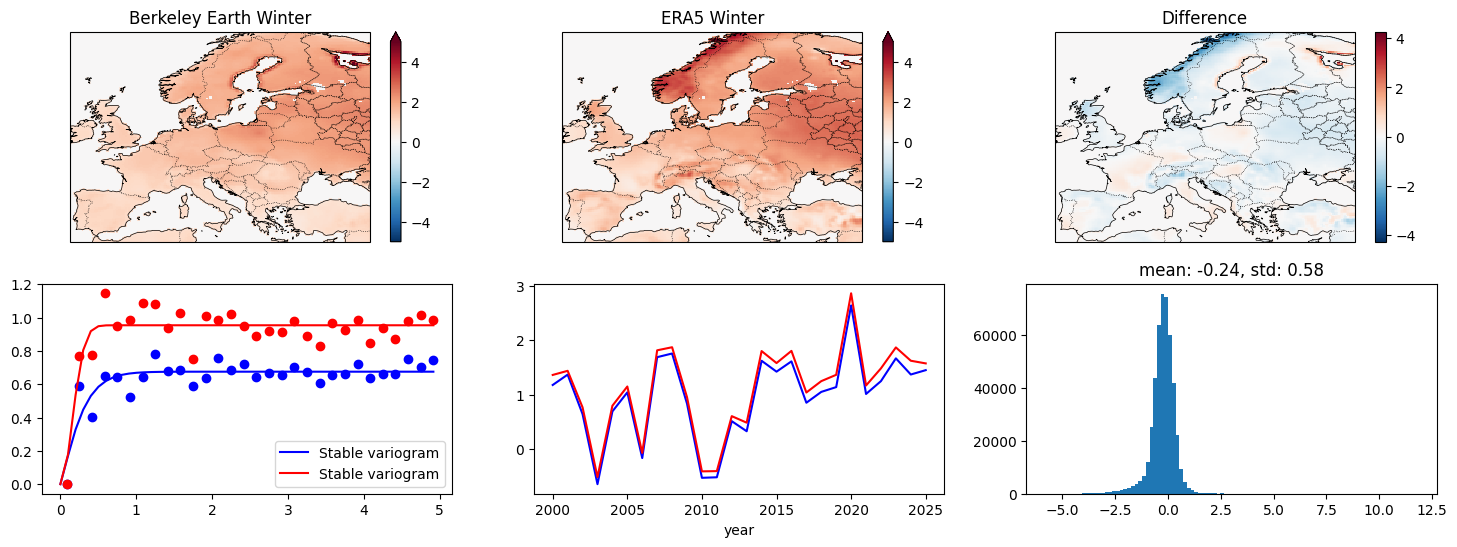

In [20]:
ds1 = BE_winter
ds2 = ER_winter
lats = TAVG.be_slice.latitude
lons = TAVG.be_slice.longitude
map_plots_v2(ds1,ds2,'Berkeley Earth Winter','ERA5 Winter',lats,lons)

In [ ]:
import gstools as gs
def variogram(lats,lons,temps):
    bc,gamma = gs.vario_estimate(
        (lons, lats), temps,
        mesh_type="structured",
        latlon=True,
        geo_scale=np.degrees(1.0),
        bin_no=30,
        max_dist=20,
        sampling_size=4000
    )
    fit_model = gs.Stable(dim=2)
    fit_model.fit_variogram(bc,gamma,nugget=False)
    return fit_model, bc, gamma



def plot_temp(temp,cmin,cmax,cmap,ax1):
    temp.plot(ax=ax1, transform=ccrs.PlateCarree(),vmin=cmin,vmax=cmax,cmap=cmap,add_colorbar=False)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax1.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax1.add_feature(cfeature.STATES, linestyle=':', linewidth=0.5)
    ax1.set_extent([-140, -100, 20, 60], crs=ccrs.PlateCarree())
    ax1.set_title('')

def plot_variogram(lats,lons,be,era5,ax1):
    fit_model, bc, gamma = variogram(lats,lons,be)
    er_model, er_bc, er_gamma = variogram(lats,lons,era5)
    fit_model.plot(ax=ax1,color='blue',x_max=max(bc))
    ax1.scatter(bc,gamma,color='blue')
    er_model.plot(ax=ax1,color='red',x_max=max(er_bc))
    ax1.scatter(er_bc,er_gamma,color='red')






num_rows, num_cols = 3, 4
plt.figure(figsize=(18, 6))
cmin = -5
cmax = 5
cmap='RdBu_r'
lats = TAVG.be_slice['latitude'].values
lons = TAVG.be_slice['longitude'].values
for i in range(num_cols):  
    
    be = TAVG.be_slice.temperature.isel(time=-(i+1))
    er = TAVG.era5_slice.temperature.isel(time=-(i+1))

    # Berkeley Earth row 1
    ax1 = plt.subplot(num_rows, num_cols, i + 1, projection=ccrs.PlateCarree())
    plot_temp(be, cmin, cmax, cmap, ax1)
    ax1.set_title(be.time.dt.strftime('%B %Y').item())
    if i == 0:
        ax1.set_ylabel('Berkeley Earth')

    # ERA5 row 2
    ax1 = plt.subplot(num_rows, num_cols, i + 1 + num_cols, projection=ccrs.PlateCarree())
    plot_temp(er, cmin, cmax, cmap, ax1)
    if i == 0:
        ax1.set_ylabel('ERA5')

    # variogram row3
    ax1 = plt.subplot(num_rows, num_cols, i + 1 + (2*num_cols))
    plot_variogram(lats,lons,be,er,ax1)